In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [8]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [9]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [10]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [11]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['swing'] = df['description'].apply(is_swing)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [12]:
# Apply the function to the 'pitch_type' column
training_data  = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
testing_data_processed = preprocess_data(testing_data, height_df)


In [13]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [14]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [15]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [16]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [17]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [18]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [19]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [20]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6962814142896672
Log Loss: 0.6032517034254566


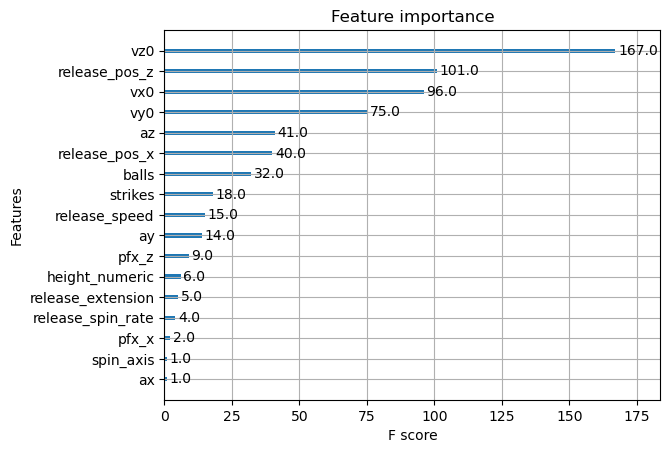

In [21]:
xgb.plot_importance(model)
plt.show()

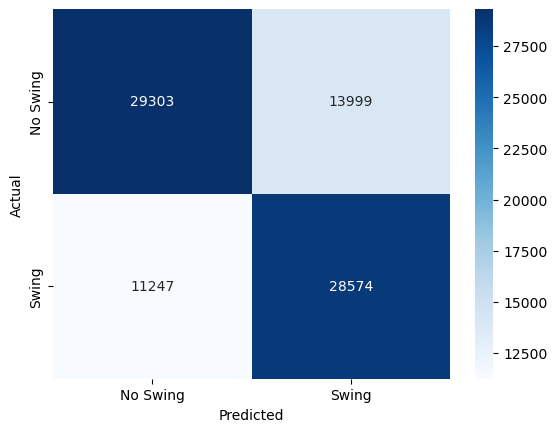

In [22]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [25]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [26]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-11-09 15:01:52,216] A new study created in memory with name: no-name-f4f1c80e-7e57-443e-840d-38f406851577


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.63838
[2]	eval-logloss:0.61959
[3]	eval-logloss:0.60864
[4]	eval-logloss:0.60131
[5]	eval-logloss:0.59184
[6]	eval-logloss:0.58477
[7]	eval-logloss:0.58332
[8]	eval-logloss:0.57736
[9]	eval-logloss:0.56971
[10]	eval-logloss:0.56431
[11]	eval-logloss:0.56136
[12]	eval-logloss:0.55972
[13]	eval-logloss:0.54928
[14]	eval-logloss:0.54069
[15]	eval-logloss:0.53599
[16]	eval-logloss:0.53334
[17]	eval-logloss:0.52764
[18]	eval-logloss:0.52446
[19]	eval-logloss:0.52172
[20]	eval-logloss:0.52099
[21]	eval-logloss:0.52042
[22]	eval-logloss:0.51765
[23]	eval-logloss:0.51138
[24]	eval-logloss:0.51057
[25]	eval-logloss:0.51024
[26]	eval-logloss:0.50928
[27]	eval-logloss:0.50875
[28]	eval-logloss:0.50532
[29]	eval-logloss:0.50499
[30]	eval-logloss:0.50056
[31]	eval-logloss:0.49935
[32]	eval-logloss:0.49833
[33]	eval-logloss:0.49583
[34]	eval-logloss:0.49503
[35]	eval-logloss:0.49316
[36]	eval-logloss:0.49302
[37]	eval-logloss:0.49213
[38]	eval-logloss:0.49

[I 2023-11-09 15:01:56,159] Trial 0 finished with value: 0.4626791973226037 and parameters: {'max_depth': 6, 'eta': 0.26214724789049115, 'subsample': 0.86859405570621, 'colsample_bytree': 0.63633307604968}. Best is trial 0 with value: 0.4626791973226037.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65481
[5]	eval-logloss:0.64988
[6]	eval-logloss:0.64524
[7]	eval-logloss:0.64106
[8]	eval-logloss:0.63814
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.63276
[11]	eval-logloss:0.62963
[12]	eval-logloss:0.62741
[13]	eval-logloss:0.62572
[14]	eval-logloss:0.62370
[15]	eval-logloss:0.62189
[16]	eval-logloss:0.61960
[17]	eval-logloss:0.61736
[18]	eval-logloss:0.61556
[19]	eval-logloss:0.61450
[20]	eval-logloss:0.61328
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60955
[23]	eval-logloss:0.60817
[24]	eval-logloss:0.60748
[25]	eval-logloss:0.60640
[26]	eval-logloss:0.60346
[27]	eval-logloss:0.60190
[28]	eval-logloss:0.60126
[29]	eval-logloss:0.60068
[30]	eval-logloss:0.59973
[31]	eval-logloss:0.59832
[32]	eval-logloss:0.59669
[33]	eval-logloss:0.59439
[34]	eval-logloss:0.59348
[35]	eval-logloss:0.59155
[36]	eval-logloss:0.59021
[37]	eval-logloss:0.58956
[38]	eval-logloss:0.58

[I 2023-11-09 15:01:59,113] Trial 1 finished with value: 0.5386903521395846 and parameters: {'max_depth': 3, 'eta': 0.11903975022895373, 'subsample': 0.7234311262719403, 'colsample_bytree': 0.9204903850874259}. Best is trial 1 with value: 0.5386903521395846.


[0]	eval-logloss:0.65024
[1]	eval-logloss:0.62552
[2]	eval-logloss:0.60787
[3]	eval-logloss:0.59546
[4]	eval-logloss:0.58568
[5]	eval-logloss:0.57940
[6]	eval-logloss:0.57287
[7]	eval-logloss:0.56775
[8]	eval-logloss:0.56431
[9]	eval-logloss:0.55506
[10]	eval-logloss:0.54360
[11]	eval-logloss:0.53945
[12]	eval-logloss:0.53605
[13]	eval-logloss:0.53036
[14]	eval-logloss:0.52607
[15]	eval-logloss:0.52191
[16]	eval-logloss:0.51940
[17]	eval-logloss:0.51765
[18]	eval-logloss:0.51336
[19]	eval-logloss:0.51047
[20]	eval-logloss:0.50833
[21]	eval-logloss:0.50789
[22]	eval-logloss:0.50580
[23]	eval-logloss:0.50368
[24]	eval-logloss:0.50066
[25]	eval-logloss:0.50032
[26]	eval-logloss:0.49973
[27]	eval-logloss:0.49927
[28]	eval-logloss:0.49702
[29]	eval-logloss:0.49363
[30]	eval-logloss:0.49122
[31]	eval-logloss:0.49055
[32]	eval-logloss:0.49041
[33]	eval-logloss:0.48655
[34]	eval-logloss:0.48501
[35]	eval-logloss:0.48409
[36]	eval-logloss:0.48152
[37]	eval-logloss:0.48072
[38]	eval-logloss:0.48

[I 2023-11-09 15:02:03,488] Trial 2 finished with value: 0.4573500456144179 and parameters: {'max_depth': 6, 'eta': 0.29954156696399736, 'subsample': 0.6488072768086397, 'colsample_bytree': 0.7560787264692042}. Best is trial 1 with value: 0.5386903521395846.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.64922
[3]	eval-logloss:0.63617
[4]	eval-logloss:0.62797
[5]	eval-logloss:0.61588
[6]	eval-logloss:0.60721
[7]	eval-logloss:0.60696
[8]	eval-logloss:0.60187
[9]	eval-logloss:0.59933
[10]	eval-logloss:0.59053
[11]	eval-logloss:0.58559
[12]	eval-logloss:0.58034
[13]	eval-logloss:0.57990
[14]	eval-logloss:0.57403
[15]	eval-logloss:0.56602
[16]	eval-logloss:0.56044
[17]	eval-logloss:0.55628
[18]	eval-logloss:0.54966
[19]	eval-logloss:0.54602
[20]	eval-logloss:0.54444
[21]	eval-logloss:0.54388
[22]	eval-logloss:0.54187
[23]	eval-logloss:0.53735
[24]	eval-logloss:0.53588
[25]	eval-logloss:0.53559
[26]	eval-logloss:0.53433
[27]	eval-logloss:0.53131
[28]	eval-logloss:0.53115
[29]	eval-logloss:0.53110
[30]	eval-logloss:0.52696
[31]	eval-logloss:0.52466
[32]	eval-logloss:0.52379
[33]	eval-logloss:0.52365
[34]	eval-logloss:0.52221
[35]	eval-logloss:0.51854
[36]	eval-logloss:0.51851
[37]	eval-logloss:0.51746
[38]	eval-logloss:0.51

[I 2023-11-09 15:02:14,310] Trial 3 finished with value: 0.4746530110400045 and parameters: {'max_depth': 9, 'eta': 0.12312728211397855, 'subsample': 0.7355472152301459, 'colsample_bytree': 0.5274697929302006}. Best is trial 1 with value: 0.5386903521395846.


[0]	eval-logloss:0.68425
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.67088
[3]	eval-logloss:0.66459
[4]	eval-logloss:0.65886
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.63801
[10]	eval-logloss:0.63491
[11]	eval-logloss:0.63226
[12]	eval-logloss:0.62943
[13]	eval-logloss:0.62714
[14]	eval-logloss:0.62480
[15]	eval-logloss:0.62297
[16]	eval-logloss:0.62009
[17]	eval-logloss:0.61773
[18]	eval-logloss:0.61553
[19]	eval-logloss:0.61356
[20]	eval-logloss:0.61226
[21]	eval-logloss:0.61069
[22]	eval-logloss:0.60874
[23]	eval-logloss:0.60764
[24]	eval-logloss:0.60573
[25]	eval-logloss:0.60493
[26]	eval-logloss:0.60361
[27]	eval-logloss:0.60269
[28]	eval-logloss:0.60018
[29]	eval-logloss:0.59869
[30]	eval-logloss:0.59755
[31]	eval-logloss:0.59649
[32]	eval-logloss:0.59578
[33]	eval-logloss:0.59344
[34]	eval-logloss:0.59244
[35]	eval-logloss:0.59137
[36]	eval-logloss:0.58943
[37]	eval-logloss:0.58809
[38]	eval-logloss:0.58

[I 2023-11-09 15:02:20,611] Trial 4 finished with value: 0.5430797348474082 and parameters: {'max_depth': 4, 'eta': 0.07166740135880997, 'subsample': 0.6103872647811553, 'colsample_bytree': 0.8039751784694621}. Best is trial 4 with value: 0.5430797348474082.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68440
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68051
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67520
[9]	eval-logloss:0.67288
[10]	eval-logloss:0.67055
[11]	eval-logloss:0.66881
[12]	eval-logloss:0.66686
[13]	eval-logloss:0.66516
[14]	eval-logloss:0.66313
[15]	eval-logloss:0.66161
[16]	eval-logloss:0.65980
[17]	eval-logloss:0.65780
[18]	eval-logloss:0.65624
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65371
[21]	eval-logloss:0.65262
[22]	eval-logloss:0.65097
[23]	eval-logloss:0.64974
[24]	eval-logloss:0.64813
[25]	eval-logloss:0.64744
[26]	eval-logloss:0.64610
[27]	eval-logloss:0.64460
[28]	eval-logloss:0.64336
[29]	eval-logloss:0.64244
[30]	eval-logloss:0.64133
[31]	eval-logloss:0.63991
[32]	eval-logloss:0.63855
[33]	eval-logloss:0.63709
[34]	eval-logloss:0.63566
[35]	eval-logloss:0.63450
[36]	eval-logloss:0.63347
[37]	eval-logloss:0.63243
[38]	eval-logloss:0.63

[I 2023-11-09 15:02:27,366] Trial 5 finished with value: 0.5865127088108281 and parameters: {'max_depth': 6, 'eta': 0.016932153966632772, 'subsample': 0.7884817843230213, 'colsample_bytree': 0.7128003770747702}. Best is trial 5 with value: 0.5865127088108281.


[0]	eval-logloss:0.66925
[1]	eval-logloss:0.64137
[2]	eval-logloss:0.62265
[3]	eval-logloss:0.61060
[4]	eval-logloss:0.60282
[5]	eval-logloss:0.59293
[6]	eval-logloss:0.58341
[7]	eval-logloss:0.58197
[8]	eval-logloss:0.57460
[9]	eval-logloss:0.56795
[10]	eval-logloss:0.56254
[11]	eval-logloss:0.55968
[12]	eval-logloss:0.55549
[13]	eval-logloss:0.54685
[14]	eval-logloss:0.54199
[15]	eval-logloss:0.53799
[16]	eval-logloss:0.53262
[17]	eval-logloss:0.52944
[18]	eval-logloss:0.52507
[19]	eval-logloss:0.52281
[20]	eval-logloss:0.52161
[21]	eval-logloss:0.52076
[22]	eval-logloss:0.51859
[23]	eval-logloss:0.51433
[24]	eval-logloss:0.51334
[25]	eval-logloss:0.51312
[26]	eval-logloss:0.51256
[27]	eval-logloss:0.51146
[28]	eval-logloss:0.50887
[29]	eval-logloss:0.50832
[30]	eval-logloss:0.50585
[31]	eval-logloss:0.50448
[32]	eval-logloss:0.50352
[33]	eval-logloss:0.50222
[34]	eval-logloss:0.50130
[35]	eval-logloss:0.49677
[36]	eval-logloss:0.49667
[37]	eval-logloss:0.49425
[38]	eval-logloss:0.49

[I 2023-11-09 15:02:33,596] Trial 6 finished with value: 0.4636323750606771 and parameters: {'max_depth': 7, 'eta': 0.2164665806784033, 'subsample': 0.8614666149577275, 'colsample_bytree': 0.6592246713377449}. Best is trial 5 with value: 0.5865127088108281.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63647
[3]	eval-logloss:0.62347
[4]	eval-logloss:0.61257
[5]	eval-logloss:0.60444
[6]	eval-logloss:0.59675
[7]	eval-logloss:0.58960
[8]	eval-logloss:0.58361
[9]	eval-logloss:0.57810
[10]	eval-logloss:0.57256
[11]	eval-logloss:0.56800
[12]	eval-logloss:0.56497
[13]	eval-logloss:0.56001
[14]	eval-logloss:0.55521
[15]	eval-logloss:0.55085
[16]	eval-logloss:0.54761
[17]	eval-logloss:0.54423
[18]	eval-logloss:0.53941
[19]	eval-logloss:0.53648
[20]	eval-logloss:0.53490
[21]	eval-logloss:0.53378
[22]	eval-logloss:0.53146
[23]	eval-logloss:0.52885
[24]	eval-logloss:0.52662
[25]	eval-logloss:0.52623
[26]	eval-logloss:0.52542
[27]	eval-logloss:0.52394
[28]	eval-logloss:0.51882
[29]	eval-logloss:0.51656
[30]	eval-logloss:0.51222
[31]	eval-logloss:0.51093
[32]	eval-logloss:0.51030
[33]	eval-logloss:0.50727
[34]	eval-logloss:0.50600
[35]	eval-logloss:0.50404
[36]	eval-logloss:0.50173
[37]	eval-logloss:0.50064
[38]	eval-logloss:0.49

[I 2023-11-09 15:02:40,685] Trial 7 finished with value: 0.46181579962900526 and parameters: {'max_depth': 8, 'eta': 0.12993769953019316, 'subsample': 0.6831801801420042, 'colsample_bytree': 0.7281970255964922}. Best is trial 5 with value: 0.5865127088108281.


[0]	eval-logloss:0.67118
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64771
[3]	eval-logloss:0.63985
[4]	eval-logloss:0.63231
[5]	eval-logloss:0.62782
[6]	eval-logloss:0.62048
[7]	eval-logloss:0.61594
[8]	eval-logloss:0.61329
[9]	eval-logloss:0.60822
[10]	eval-logloss:0.60272
[11]	eval-logloss:0.60036
[12]	eval-logloss:0.59821
[13]	eval-logloss:0.59711
[14]	eval-logloss:0.59450
[15]	eval-logloss:0.58973
[16]	eval-logloss:0.58867
[17]	eval-logloss:0.58721
[18]	eval-logloss:0.58306
[19]	eval-logloss:0.57998
[20]	eval-logloss:0.57922
[21]	eval-logloss:0.57640
[22]	eval-logloss:0.57176
[23]	eval-logloss:0.56899
[24]	eval-logloss:0.56703
[25]	eval-logloss:0.56625
[26]	eval-logloss:0.56431
[27]	eval-logloss:0.56281
[28]	eval-logloss:0.56182
[29]	eval-logloss:0.56133
[30]	eval-logloss:0.55878
[31]	eval-logloss:0.55706
[32]	eval-logloss:0.55620
[33]	eval-logloss:0.55457
[34]	eval-logloss:0.55361
[35]	eval-logloss:0.55107
[36]	eval-logloss:0.55016
[37]	eval-logloss:0.54944
[38]	eval-logloss:0.54

[I 2023-11-09 15:02:45,612] Trial 8 finished with value: 0.5100451878505436 and parameters: {'max_depth': 3, 'eta': 0.24788148975442373, 'subsample': 0.875528596779195, 'colsample_bytree': 0.8931091817006569}. Best is trial 5 with value: 0.5865127088108281.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63753
[4]	eval-logloss:0.62811
[5]	eval-logloss:0.61970
[6]	eval-logloss:0.61293
[7]	eval-logloss:0.60731
[8]	eval-logloss:0.60233
[9]	eval-logloss:0.59763
[10]	eval-logloss:0.59402
[11]	eval-logloss:0.58984
[12]	eval-logloss:0.58704
[13]	eval-logloss:0.58324
[14]	eval-logloss:0.57850
[15]	eval-logloss:0.57620
[16]	eval-logloss:0.57363
[17]	eval-logloss:0.57061
[18]	eval-logloss:0.56755
[19]	eval-logloss:0.56468
[20]	eval-logloss:0.56228
[21]	eval-logloss:0.56022
[22]	eval-logloss:0.55900
[23]	eval-logloss:0.55575
[24]	eval-logloss:0.55437
[25]	eval-logloss:0.55397
[26]	eval-logloss:0.55294
[27]	eval-logloss:0.55164
[28]	eval-logloss:0.54978
[29]	eval-logloss:0.54861
[30]	eval-logloss:0.54571
[31]	eval-logloss:0.54396
[32]	eval-logloss:0.54253
[33]	eval-logloss:0.53797
[34]	eval-logloss:0.53596
[35]	eval-logloss:0.53504
[36]	eval-logloss:0.53154
[37]	eval-logloss:0.52950
[38]	eval-logloss:0.52

[I 2023-11-09 15:02:54,539] Trial 9 finished with value: 0.48299634013568826 and parameters: {'max_depth': 6, 'eta': 0.11688438682100431, 'subsample': 0.8086411619693099, 'colsample_bytree': 0.8220525534612858}. Best is trial 5 with value: 0.5865127088108281.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68703
[4]	eval-logloss:0.68551
[5]	eval-logloss:0.68399
[6]	eval-logloss:0.68252
[7]	eval-logloss:0.68109
[8]	eval-logloss:0.67974
[9]	eval-logloss:0.67833
[10]	eval-logloss:0.67694
[11]	eval-logloss:0.67561
[12]	eval-logloss:0.67430
[13]	eval-logloss:0.67325
[14]	eval-logloss:0.67196
[15]	eval-logloss:0.67072
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66825
[18]	eval-logloss:0.66710
[19]	eval-logloss:0.66591
[20]	eval-logloss:0.66476
[21]	eval-logloss:0.66368
[22]	eval-logloss:0.66253
[23]	eval-logloss:0.66161
[24]	eval-logloss:0.66054
[25]	eval-logloss:0.65945
[26]	eval-logloss:0.65845
[27]	eval-logloss:0.65743
[28]	eval-logloss:0.65646
[29]	eval-logloss:0.65541
[30]	eval-logloss:0.65440
[31]	eval-logloss:0.65346
[32]	eval-logloss:0.65252
[33]	eval-logloss:0.65165
[34]	eval-logloss:0.65069
[35]	eval-logloss:0.64972
[36]	eval-logloss:0.64880
[37]	eval-logloss:0.64791
[38]	eval-logloss:0.64

[I 2023-11-09 15:03:00,828] Trial 10 finished with value: 0.6111975300250272 and parameters: {'max_depth': 5, 'eta': 0.011219604361229667, 'subsample': 0.8004016883382259, 'colsample_bytree': 0.9455238732785762}. Best is trial 10 with value: 0.6111975300250272.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68697
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68240
[7]	eval-logloss:0.68096
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67816
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67540
[12]	eval-logloss:0.67406
[13]	eval-logloss:0.67299
[14]	eval-logloss:0.67175
[15]	eval-logloss:0.67050
[16]	eval-logloss:0.66928
[17]	eval-logloss:0.66803
[18]	eval-logloss:0.66685
[19]	eval-logloss:0.66566
[20]	eval-logloss:0.66452
[21]	eval-logloss:0.66341
[22]	eval-logloss:0.66228
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66027
[25]	eval-logloss:0.65919
[26]	eval-logloss:0.65818
[27]	eval-logloss:0.65715
[28]	eval-logloss:0.65618
[29]	eval-logloss:0.65513
[30]	eval-logloss:0.65410
[31]	eval-logloss:0.65316
[32]	eval-logloss:0.65218
[33]	eval-logloss:0.65130
[34]	eval-logloss:0.65034
[35]	eval-logloss:0.64937
[36]	eval-logloss:0.64849
[37]	eval-logloss:0.64759
[38]	eval-logloss:0.64

[I 2023-11-09 15:03:06,826] Trial 11 finished with value: 0.6106835487917198 and parameters: {'max_depth': 5, 'eta': 0.011348532596476918, 'subsample': 0.7918618132090902, 'colsample_bytree': 0.9819857450258276}. Best is trial 10 with value: 0.6111975300250272.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68361
[5]	eval-logloss:0.68177
[6]	eval-logloss:0.67998
[7]	eval-logloss:0.67829
[8]	eval-logloss:0.67666
[9]	eval-logloss:0.67502
[10]	eval-logloss:0.67339
[11]	eval-logloss:0.67186
[12]	eval-logloss:0.67034
[13]	eval-logloss:0.66917
[14]	eval-logloss:0.66775
[15]	eval-logloss:0.66635
[16]	eval-logloss:0.66502
[17]	eval-logloss:0.66367
[18]	eval-logloss:0.66239
[19]	eval-logloss:0.66110
[20]	eval-logloss:0.65986
[21]	eval-logloss:0.65869
[22]	eval-logloss:0.65746
[23]	eval-logloss:0.65648
[24]	eval-logloss:0.65529
[25]	eval-logloss:0.65416
[26]	eval-logloss:0.65307
[27]	eval-logloss:0.65200
[28]	eval-logloss:0.65097
[29]	eval-logloss:0.64991
[30]	eval-logloss:0.64896
[31]	eval-logloss:0.64799
[32]	eval-logloss:0.64699
[33]	eval-logloss:0.64611
[34]	eval-logloss:0.64516
[35]	eval-logloss:0.64424
[36]	eval-logloss:0.64335
[37]	eval-logloss:0.64254
[38]	eval-logloss:0.64

[I 2023-11-09 15:03:12,285] Trial 12 finished with value: 0.6097019978927086 and parameters: {'max_depth': 4, 'eta': 0.016540373322857987, 'subsample': 0.7941560819298911, 'colsample_bytree': 0.9980905818764347}. Best is trial 10 with value: 0.6111975300250272.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.67317
[3]	eval-logloss:0.66702
[4]	eval-logloss:0.66174
[5]	eval-logloss:0.65661
[6]	eval-logloss:0.65182
[7]	eval-logloss:0.64740
[8]	eval-logloss:0.64313
[9]	eval-logloss:0.63947
[10]	eval-logloss:0.63579
[11]	eval-logloss:0.63241
[12]	eval-logloss:0.62916
[13]	eval-logloss:0.62651
[14]	eval-logloss:0.62374
[15]	eval-logloss:0.62124
[16]	eval-logloss:0.61849
[17]	eval-logloss:0.61623
[18]	eval-logloss:0.61364
[19]	eval-logloss:0.61194
[20]	eval-logloss:0.61024
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60637
[23]	eval-logloss:0.60453
[24]	eval-logloss:0.60280
[25]	eval-logloss:0.60158
[26]	eval-logloss:0.60038
[27]	eval-logloss:0.59943
[28]	eval-logloss:0.59808
[29]	eval-logloss:0.59620
[30]	eval-logloss:0.59471
[31]	eval-logloss:0.59353
[32]	eval-logloss:0.59224
[33]	eval-logloss:0.59110
[34]	eval-logloss:0.58997
[35]	eval-logloss:0.58901
[36]	eval-logloss:0.58778
[37]	eval-logloss:0.58657
[38]	eval-logloss:0.58

[I 2023-11-09 15:03:19,024] Trial 13 finished with value: 0.537295233797459 and parameters: {'max_depth': 5, 'eta': 0.05409047286788222, 'subsample': 0.8246428078519468, 'colsample_bytree': 0.9995384283413921}. Best is trial 10 with value: 0.6111975300250272.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68748
[4]	eval-logloss:0.68606
[5]	eval-logloss:0.68465
[6]	eval-logloss:0.68324
[7]	eval-logloss:0.68193
[8]	eval-logloss:0.68065
[9]	eval-logloss:0.67933
[10]	eval-logloss:0.67803
[11]	eval-logloss:0.67679
[12]	eval-logloss:0.67557
[13]	eval-logloss:0.67464
[14]	eval-logloss:0.67344
[15]	eval-logloss:0.67227
[16]	eval-logloss:0.67109
[17]	eval-logloss:0.66992
[18]	eval-logloss:0.66881
[19]	eval-logloss:0.66769
[20]	eval-logloss:0.66663
[21]	eval-logloss:0.66560
[22]	eval-logloss:0.66454
[23]	eval-logloss:0.66367
[24]	eval-logloss:0.66269
[25]	eval-logloss:0.66164
[26]	eval-logloss:0.66068
[27]	eval-logloss:0.65972
[28]	eval-logloss:0.65893
[29]	eval-logloss:0.65796
[30]	eval-logloss:0.65712
[31]	eval-logloss:0.65625
[32]	eval-logloss:0.65530
[33]	eval-logloss:0.65440
[34]	eval-logloss:0.65350
[35]	eval-logloss:0.65257
[36]	eval-logloss:0.65172
[37]	eval-logloss:0.65085
[38]	eval-logloss:0.65

[I 2023-11-09 15:03:24,830] Trial 14 finished with value: 0.6150295072542282 and parameters: {'max_depth': 5, 'eta': 0.010372039431477648, 'subsample': 0.7665898394010563, 'colsample_bytree': 0.9235561987654264}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.66985
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65695
[5]	eval-logloss:0.65122
[6]	eval-logloss:0.64582
[7]	eval-logloss:0.64134
[8]	eval-logloss:0.63680
[9]	eval-logloss:0.63294
[10]	eval-logloss:0.62897
[11]	eval-logloss:0.62570
[12]	eval-logloss:0.62235
[13]	eval-logloss:0.61954
[14]	eval-logloss:0.61695
[15]	eval-logloss:0.61467
[16]	eval-logloss:0.61248
[17]	eval-logloss:0.60993
[18]	eval-logloss:0.60729
[19]	eval-logloss:0.60502
[20]	eval-logloss:0.60341
[21]	eval-logloss:0.60098
[22]	eval-logloss:0.59898
[23]	eval-logloss:0.59684
[24]	eval-logloss:0.59555
[25]	eval-logloss:0.59378
[26]	eval-logloss:0.59256
[27]	eval-logloss:0.59159
[28]	eval-logloss:0.58972
[29]	eval-logloss:0.58831
[30]	eval-logloss:0.58687
[31]	eval-logloss:0.58541
[32]	eval-logloss:0.58416
[33]	eval-logloss:0.58309
[34]	eval-logloss:0.58111
[35]	eval-logloss:0.57933
[36]	eval-logloss:0.57804
[37]	eval-logloss:0.57719
[38]	eval-logloss:0.57

[I 2023-11-09 15:03:30,892] Trial 15 finished with value: 0.5286614094816526 and parameters: {'max_depth': 5, 'eta': 0.06388831819568742, 'subsample': 0.7519686624461931, 'colsample_bytree': 0.8976880129734394}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.65724
[2]	eval-logloss:0.64729
[3]	eval-logloss:0.63743
[4]	eval-logloss:0.63009
[5]	eval-logloss:0.62303
[6]	eval-logloss:0.61848
[7]	eval-logloss:0.61441
[8]	eval-logloss:0.61085
[9]	eval-logloss:0.60498
[10]	eval-logloss:0.60121
[11]	eval-logloss:0.59925
[12]	eval-logloss:0.59553
[13]	eval-logloss:0.59162
[14]	eval-logloss:0.58950
[15]	eval-logloss:0.58452
[16]	eval-logloss:0.58240
[17]	eval-logloss:0.57782
[18]	eval-logloss:0.57568
[19]	eval-logloss:0.57483
[20]	eval-logloss:0.57287
[21]	eval-logloss:0.57134
[22]	eval-logloss:0.56907
[23]	eval-logloss:0.56779
[24]	eval-logloss:0.56603
[25]	eval-logloss:0.56335
[26]	eval-logloss:0.56223
[27]	eval-logloss:0.56143
[28]	eval-logloss:0.55766
[29]	eval-logloss:0.55615
[30]	eval-logloss:0.55501
[31]	eval-logloss:0.55432
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.54938
[34]	eval-logloss:0.54719
[35]	eval-logloss:0.54492
[36]	eval-logloss:0.54423
[37]	eval-logloss:0.54284
[38]	eval-logloss:0.54

[I 2023-11-09 15:03:37,556] Trial 16 finished with value: 0.4993926816957402 and parameters: {'max_depth': 4, 'eta': 0.17904226417563168, 'subsample': 0.7591344325278401, 'colsample_bytree': 0.8627540669229121}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67613
[2]	eval-logloss:0.66972
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65636
[5]	eval-logloss:0.65009
[6]	eval-logloss:0.64443
[7]	eval-logloss:0.63949
[8]	eval-logloss:0.63523
[9]	eval-logloss:0.63078
[10]	eval-logloss:0.62602
[11]	eval-logloss:0.62212
[12]	eval-logloss:0.61821
[13]	eval-logloss:0.61466
[14]	eval-logloss:0.61108
[15]	eval-logloss:0.60751
[16]	eval-logloss:0.60429
[17]	eval-logloss:0.60136
[18]	eval-logloss:0.59873
[19]	eval-logloss:0.59611
[20]	eval-logloss:0.59403
[21]	eval-logloss:0.59147
[22]	eval-logloss:0.58906
[23]	eval-logloss:0.58664
[24]	eval-logloss:0.58465
[25]	eval-logloss:0.58274
[26]	eval-logloss:0.58105
[27]	eval-logloss:0.57954
[28]	eval-logloss:0.57757
[29]	eval-logloss:0.57590
[30]	eval-logloss:0.57431
[31]	eval-logloss:0.57302
[32]	eval-logloss:0.57173
[33]	eval-logloss:0.57001
[34]	eval-logloss:0.56817
[35]	eval-logloss:0.56576
[36]	eval-logloss:0.56445
[37]	eval-logloss:0.56277
[38]	eval-logloss:0.56

[I 2023-11-09 15:03:46,916] Trial 17 finished with value: 0.5087368304979776 and parameters: {'max_depth': 7, 'eta': 0.05006953818281251, 'subsample': 0.8360522518617111, 'colsample_bytree': 0.9436917602267838}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66410
[2]	eval-logloss:0.65406
[3]	eval-logloss:0.64387
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.61994
[7]	eval-logloss:0.61366
[8]	eval-logloss:0.60841
[9]	eval-logloss:0.60329
[10]	eval-logloss:0.59786
[11]	eval-logloss:0.59376
[12]	eval-logloss:0.59022
[13]	eval-logloss:0.58645
[14]	eval-logloss:0.58341
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57565
[17]	eval-logloss:0.57199
[18]	eval-logloss:0.56939
[19]	eval-logloss:0.56679
[20]	eval-logloss:0.56456
[21]	eval-logloss:0.56147
[22]	eval-logloss:0.55961
[23]	eval-logloss:0.55696
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.55102
[27]	eval-logloss:0.54962
[28]	eval-logloss:0.54666
[29]	eval-logloss:0.54472
[30]	eval-logloss:0.54344
[31]	eval-logloss:0.54184
[32]	eval-logloss:0.54022
[33]	eval-logloss:0.53824
[34]	eval-logloss:0.53544
[35]	eval-logloss:0.53391
[36]	eval-logloss:0.53192
[37]	eval-logloss:0.53025
[38]	eval-logloss:0.52

[I 2023-11-09 15:03:54,382] Trial 18 finished with value: 0.48009686026534903 and parameters: {'max_depth': 7, 'eta': 0.08922113380982659, 'subsample': 0.8929516947570806, 'colsample_bytree': 0.855237496323678}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.68754
[1]	eval-logloss:0.68235
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.66944
[5]	eval-logloss:0.66534
[6]	eval-logloss:0.66150
[7]	eval-logloss:0.65787
[8]	eval-logloss:0.65450
[9]	eval-logloss:0.65122
[10]	eval-logloss:0.64793
[11]	eval-logloss:0.64493
[12]	eval-logloss:0.64203
[13]	eval-logloss:0.63972
[14]	eval-logloss:0.63686
[15]	eval-logloss:0.63459
[16]	eval-logloss:0.63221
[17]	eval-logloss:0.62979
[18]	eval-logloss:0.62774
[19]	eval-logloss:0.62569
[20]	eval-logloss:0.62394
[21]	eval-logloss:0.62206
[22]	eval-logloss:0.62024
[23]	eval-logloss:0.61864
[24]	eval-logloss:0.61710
[25]	eval-logloss:0.61537
[26]	eval-logloss:0.61381
[27]	eval-logloss:0.61257
[28]	eval-logloss:0.61128
[29]	eval-logloss:0.60987
[30]	eval-logloss:0.60848
[31]	eval-logloss:0.60748
[32]	eval-logloss:0.60580
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60337
[35]	eval-logloss:0.60187
[36]	eval-logloss:0.60066
[37]	eval-logloss:0.59941
[38]	eval-logloss:0.59

[I 2023-11-09 15:04:01,023] Trial 19 finished with value: 0.5573136322730528 and parameters: {'max_depth': 5, 'eta': 0.03856713574588213, 'subsample': 0.7670475649380415, 'colsample_bytree': 0.9398986315536697}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66452
[3]	eval-logloss:0.65694
[4]	eval-logloss:0.65016
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.63933
[7]	eval-logloss:0.63501
[8]	eval-logloss:0.63089
[9]	eval-logloss:0.62739
[10]	eval-logloss:0.62340
[11]	eval-logloss:0.62073
[12]	eval-logloss:0.61799
[13]	eval-logloss:0.61568
[14]	eval-logloss:0.61370
[15]	eval-logloss:0.61192
[16]	eval-logloss:0.60903
[17]	eval-logloss:0.60680
[18]	eval-logloss:0.60418
[19]	eval-logloss:0.60274
[20]	eval-logloss:0.60083
[21]	eval-logloss:0.59968
[22]	eval-logloss:0.59788
[23]	eval-logloss:0.59657
[24]	eval-logloss:0.59482
[25]	eval-logloss:0.59234
[26]	eval-logloss:0.59150
[27]	eval-logloss:0.59060
[28]	eval-logloss:0.58754
[29]	eval-logloss:0.58527
[30]	eval-logloss:0.58424
[31]	eval-logloss:0.58336
[32]	eval-logloss:0.58222
[33]	eval-logloss:0.58022
[34]	eval-logloss:0.57948
[35]	eval-logloss:0.57775
[36]	eval-logloss:0.57696
[37]	eval-logloss:0.57603
[38]	eval-logloss:0.57

[I 2023-11-09 15:04:06,199] Trial 20 finished with value: 0.5273817679859564 and parameters: {'max_depth': 4, 'eta': 0.09705846387072749, 'subsample': 0.7138449372106104, 'colsample_bytree': 0.9408720354336617}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68437
[5]	eval-logloss:0.68264
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67780
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67465
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67167
[13]	eval-logloss:0.67054
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66774
[16]	eval-logloss:0.66638
[17]	eval-logloss:0.66501
[18]	eval-logloss:0.66371
[19]	eval-logloss:0.66241
[20]	eval-logloss:0.66119
[21]	eval-logloss:0.66002
[22]	eval-logloss:0.65879
[23]	eval-logloss:0.65778
[24]	eval-logloss:0.65662
[25]	eval-logloss:0.65542
[26]	eval-logloss:0.65433
[27]	eval-logloss:0.65319
[28]	eval-logloss:0.65215
[29]	eval-logloss:0.65103
[30]	eval-logloss:0.64996
[31]	eval-logloss:0.64891
[32]	eval-logloss:0.64780
[33]	eval-logloss:0.64683
[34]	eval-logloss:0.64580
[35]	eval-logloss:0.64477
[36]	eval-logloss:0.64379
[37]	eval-logloss:0.64285
[38]	eval-logloss:0.64

[I 2023-11-09 15:04:12,347] Trial 21 finished with value: 0.6053446649247084 and parameters: {'max_depth': 5, 'eta': 0.012981683539778854, 'subsample': 0.7877949035682397, 'colsample_bytree': 0.9752889768972742}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68364
[2]	eval-logloss:0.68018
[3]	eval-logloss:0.67591
[4]	eval-logloss:0.67209
[5]	eval-logloss:0.66834
[6]	eval-logloss:0.66477
[7]	eval-logloss:0.66141
[8]	eval-logloss:0.65811
[9]	eval-logloss:0.65514
[10]	eval-logloss:0.65208
[11]	eval-logloss:0.64928
[12]	eval-logloss:0.64669
[13]	eval-logloss:0.64454
[14]	eval-logloss:0.64193
[15]	eval-logloss:0.63964
[16]	eval-logloss:0.63734
[17]	eval-logloss:0.63508
[18]	eval-logloss:0.63309
[19]	eval-logloss:0.63108
[20]	eval-logloss:0.62933
[21]	eval-logloss:0.62725
[22]	eval-logloss:0.62549
[23]	eval-logloss:0.62400
[24]	eval-logloss:0.62218
[25]	eval-logloss:0.62068
[26]	eval-logloss:0.61941
[27]	eval-logloss:0.61810
[28]	eval-logloss:0.61663
[29]	eval-logloss:0.61517
[30]	eval-logloss:0.61390
[31]	eval-logloss:0.61263
[32]	eval-logloss:0.61140
[33]	eval-logloss:0.61039
[34]	eval-logloss:0.60886
[35]	eval-logloss:0.60758
[36]	eval-logloss:0.60631
[37]	eval-logloss:0.60534
[38]	eval-logloss:0.60

[I 2023-11-09 15:04:18,090] Trial 22 finished with value: 0.5632858369904695 and parameters: {'max_depth': 5, 'eta': 0.03371851205458114, 'subsample': 0.8256024524311203, 'colsample_bytree': 0.9605723626119518}. Best is trial 14 with value: 0.6150295072542282.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68722
[4]	eval-logloss:0.68574
[5]	eval-logloss:0.68429
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68151
[8]	eval-logloss:0.68019
[9]	eval-logloss:0.67884
[10]	eval-logloss:0.67753
[11]	eval-logloss:0.67626
[12]	eval-logloss:0.67501
[13]	eval-logloss:0.67405
[14]	eval-logloss:0.67286
[15]	eval-logloss:0.67169
[16]	eval-logloss:0.67057
[17]	eval-logloss:0.66942
[18]	eval-logloss:0.66831
[19]	eval-logloss:0.66726
[20]	eval-logloss:0.66621
[21]	eval-logloss:0.66514
[22]	eval-logloss:0.66410
[23]	eval-logloss:0.66326
[24]	eval-logloss:0.66230
[25]	eval-logloss:0.66129
[26]	eval-logloss:0.66033
[27]	eval-logloss:0.65937
[28]	eval-logloss:0.65859
[29]	eval-logloss:0.65764
[30]	eval-logloss:0.65688
[31]	eval-logloss:0.65601
[32]	eval-logloss:0.65514
[33]	eval-logloss:0.65433
[34]	eval-logloss:0.65347
[35]	eval-logloss:0.65260
[36]	eval-logloss:0.65180
[37]	eval-logloss:0.65103
[38]	eval-logloss:0.65

[I 2023-11-09 15:04:23,331] Trial 23 finished with value: 0.6194549729560658 and parameters: {'max_depth': 4, 'eta': 0.012639639759646295, 'subsample': 0.7748466211498873, 'colsample_bytree': 0.9011715863404125}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68535
[2]	eval-logloss:0.68268
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67628
[5]	eval-logloss:0.67341
[6]	eval-logloss:0.67061
[7]	eval-logloss:0.66814
[8]	eval-logloss:0.66584
[9]	eval-logloss:0.66361
[10]	eval-logloss:0.66141
[11]	eval-logloss:0.65939
[12]	eval-logloss:0.65749
[13]	eval-logloss:0.65591
[14]	eval-logloss:0.65413
[15]	eval-logloss:0.65251
[16]	eval-logloss:0.65084
[17]	eval-logloss:0.64939
[18]	eval-logloss:0.64789
[19]	eval-logloss:0.64628
[20]	eval-logloss:0.64503
[21]	eval-logloss:0.64365
[22]	eval-logloss:0.64242
[23]	eval-logloss:0.64133
[24]	eval-logloss:0.64010
[25]	eval-logloss:0.63907
[26]	eval-logloss:0.63781
[27]	eval-logloss:0.63689
[28]	eval-logloss:0.63593
[29]	eval-logloss:0.63483
[30]	eval-logloss:0.63393
[31]	eval-logloss:0.63305
[32]	eval-logloss:0.63215
[33]	eval-logloss:0.63107
[34]	eval-logloss:0.63014
[35]	eval-logloss:0.62934
[36]	eval-logloss:0.62854
[37]	eval-logloss:0.62783
[38]	eval-logloss:0.62

[I 2023-11-09 15:04:28,490] Trial 24 finished with value: 0.591809983357281 and parameters: {'max_depth': 3, 'eta': 0.04126502439455729, 'subsample': 0.7670466853122012, 'colsample_bytree': 0.8998257145142705}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.68408
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.67057
[3]	eval-logloss:0.66405
[4]	eval-logloss:0.65838
[5]	eval-logloss:0.65328
[6]	eval-logloss:0.64850
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.64094
[9]	eval-logloss:0.63735
[10]	eval-logloss:0.63446
[11]	eval-logloss:0.63140
[12]	eval-logloss:0.62857
[13]	eval-logloss:0.62629
[14]	eval-logloss:0.62430
[15]	eval-logloss:0.62243
[16]	eval-logloss:0.61988
[17]	eval-logloss:0.61810
[18]	eval-logloss:0.61564
[19]	eval-logloss:0.61354
[20]	eval-logloss:0.61219
[21]	eval-logloss:0.61043
[22]	eval-logloss:0.60873
[23]	eval-logloss:0.60702
[24]	eval-logloss:0.60591
[25]	eval-logloss:0.60389
[26]	eval-logloss:0.60262
[27]	eval-logloss:0.60158
[28]	eval-logloss:0.60003
[29]	eval-logloss:0.59860
[30]	eval-logloss:0.59735
[31]	eval-logloss:0.59637
[32]	eval-logloss:0.59558
[33]	eval-logloss:0.59370
[34]	eval-logloss:0.59298
[35]	eval-logloss:0.59118
[36]	eval-logloss:0.58900
[37]	eval-logloss:0.58809
[38]	eval-logloss:0.58

[I 2023-11-09 15:04:33,210] Trial 25 finished with value: 0.5427818386525958 and parameters: {'max_depth': 4, 'eta': 0.07317587220334482, 'subsample': 0.7416526335791115, 'colsample_bytree': 0.8804231151677673}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67489
[5]	eval-logloss:0.67166
[6]	eval-logloss:0.66857
[7]	eval-logloss:0.66574
[8]	eval-logloss:0.66309
[9]	eval-logloss:0.66043
[10]	eval-logloss:0.65792
[11]	eval-logloss:0.65551
[12]	eval-logloss:0.65320
[13]	eval-logloss:0.65139
[14]	eval-logloss:0.64926
[15]	eval-logloss:0.64733
[16]	eval-logloss:0.64552
[17]	eval-logloss:0.64361
[18]	eval-logloss:0.64185
[19]	eval-logloss:0.64029
[20]	eval-logloss:0.63875
[21]	eval-logloss:0.63735
[22]	eval-logloss:0.63573
[23]	eval-logloss:0.63437
[24]	eval-logloss:0.63287
[25]	eval-logloss:0.63166
[26]	eval-logloss:0.63053
[27]	eval-logloss:0.62938
[28]	eval-logloss:0.62824
[29]	eval-logloss:0.62700
[30]	eval-logloss:0.62593
[31]	eval-logloss:0.62473
[32]	eval-logloss:0.62336
[33]	eval-logloss:0.62227
[34]	eval-logloss:0.62142
[35]	eval-logloss:0.62043
[36]	eval-logloss:0.61929
[37]	eval-logloss:0.61819
[38]	eval-logloss:0.61

[I 2023-11-09 15:04:38,156] Trial 26 finished with value: 0.5793415532934068 and parameters: {'max_depth': 4, 'eta': 0.033639992600077134, 'subsample': 0.7036329374930654, 'colsample_bytree': 0.9172509579855543}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67945
[2]	eval-logloss:0.67513
[3]	eval-logloss:0.66997
[4]	eval-logloss:0.66539
[5]	eval-logloss:0.66150
[6]	eval-logloss:0.65780
[7]	eval-logloss:0.65444
[8]	eval-logloss:0.65153
[9]	eval-logloss:0.64849
[10]	eval-logloss:0.64579
[11]	eval-logloss:0.64304
[12]	eval-logloss:0.64092
[13]	eval-logloss:0.63901
[14]	eval-logloss:0.63670
[15]	eval-logloss:0.63505
[16]	eval-logloss:0.63296
[17]	eval-logloss:0.63143
[18]	eval-logloss:0.62996
[19]	eval-logloss:0.62852
[20]	eval-logloss:0.62727
[21]	eval-logloss:0.62618
[22]	eval-logloss:0.62367
[23]	eval-logloss:0.62252
[24]	eval-logloss:0.62151
[25]	eval-logloss:0.61909
[26]	eval-logloss:0.61787
[27]	eval-logloss:0.61691
[28]	eval-logloss:0.61513
[29]	eval-logloss:0.61304
[30]	eval-logloss:0.61235
[31]	eval-logloss:0.61134
[32]	eval-logloss:0.60940
[33]	eval-logloss:0.60816
[34]	eval-logloss:0.60754
[35]	eval-logloss:0.60682
[36]	eval-logloss:0.60603
[37]	eval-logloss:0.60527
[38]	eval-logloss:0.60

[I 2023-11-09 15:04:42,386] Trial 27 finished with value: 0.5675924770730855 and parameters: {'max_depth': 3, 'eta': 0.0757787154762405, 'subsample': 0.7713264620497969, 'colsample_bytree': 0.8492745087302075}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.67905
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.66805
[4]	eval-logloss:0.66292
[5]	eval-logloss:0.65782
[6]	eval-logloss:0.65321
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64483
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63770
[11]	eval-logloss:0.63433
[12]	eval-logloss:0.63115
[13]	eval-logloss:0.62855
[14]	eval-logloss:0.62569
[15]	eval-logloss:0.62328
[16]	eval-logloss:0.62080
[17]	eval-logloss:0.61822
[18]	eval-logloss:0.61574
[19]	eval-logloss:0.61398
[20]	eval-logloss:0.61236
[21]	eval-logloss:0.61030
[22]	eval-logloss:0.60821
[23]	eval-logloss:0.60675
[24]	eval-logloss:0.60485
[25]	eval-logloss:0.60346
[26]	eval-logloss:0.60232
[27]	eval-logloss:0.60096
[28]	eval-logloss:0.59934
[29]	eval-logloss:0.59803
[30]	eval-logloss:0.59697
[31]	eval-logloss:0.59565
[32]	eval-logloss:0.59417
[33]	eval-logloss:0.59313
[34]	eval-logloss:0.59212
[35]	eval-logloss:0.59106
[36]	eval-logloss:0.58976
[37]	eval-logloss:0.58852
[38]	eval-logloss:0.58

[I 2023-11-09 15:04:47,694] Trial 28 finished with value: 0.5402596393204951 and parameters: {'max_depth': 5, 'eta': 0.05130399948636116, 'subsample': 0.7396479385499849, 'colsample_bytree': 0.9578065289824742}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.68836
[1]	eval-logloss:0.68372
[2]	eval-logloss:0.68022
[3]	eval-logloss:0.67591
[4]	eval-logloss:0.67199
[5]	eval-logloss:0.66832
[6]	eval-logloss:0.66488
[7]	eval-logloss:0.66177
[8]	eval-logloss:0.65868
[9]	eval-logloss:0.65546
[10]	eval-logloss:0.65235
[11]	eval-logloss:0.64964
[12]	eval-logloss:0.64703
[13]	eval-logloss:0.64468
[14]	eval-logloss:0.64195
[15]	eval-logloss:0.63984
[16]	eval-logloss:0.63735
[17]	eval-logloss:0.63475
[18]	eval-logloss:0.63231
[19]	eval-logloss:0.63047
[20]	eval-logloss:0.62839
[21]	eval-logloss:0.62659
[22]	eval-logloss:0.62448
[23]	eval-logloss:0.62263
[24]	eval-logloss:0.62073
[25]	eval-logloss:0.61996
[26]	eval-logloss:0.61849
[27]	eval-logloss:0.61676
[28]	eval-logloss:0.61503
[29]	eval-logloss:0.61340
[30]	eval-logloss:0.61182
[31]	eval-logloss:0.61046
[32]	eval-logloss:0.60905
[33]	eval-logloss:0.60747
[34]	eval-logloss:0.60587
[35]	eval-logloss:0.60426
[36]	eval-logloss:0.60286
[37]	eval-logloss:0.60145
[38]	eval-logloss:0.60

[I 2023-11-09 15:04:54,452] Trial 29 finished with value: 0.555063546216247 and parameters: {'max_depth': 6, 'eta': 0.02924606594321972, 'subsample': 0.8379925900371629, 'colsample_bytree': 0.8240474039746546}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.68334
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66701
[3]	eval-logloss:0.65914
[4]	eval-logloss:0.65257
[5]	eval-logloss:0.64622
[6]	eval-logloss:0.63992
[7]	eval-logloss:0.63411
[8]	eval-logloss:0.62940
[9]	eval-logloss:0.62490
[10]	eval-logloss:0.62009
[11]	eval-logloss:0.61601
[12]	eval-logloss:0.61209
[13]	eval-logloss:0.60859
[14]	eval-logloss:0.60452
[15]	eval-logloss:0.60094
[16]	eval-logloss:0.59776
[17]	eval-logloss:0.59483
[18]	eval-logloss:0.59220
[19]	eval-logloss:0.58982
[20]	eval-logloss:0.58786
[21]	eval-logloss:0.58576
[22]	eval-logloss:0.58319
[23]	eval-logloss:0.58060
[24]	eval-logloss:0.57856
[25]	eval-logloss:0.57659
[26]	eval-logloss:0.57495
[27]	eval-logloss:0.57350
[28]	eval-logloss:0.57146
[29]	eval-logloss:0.56998
[30]	eval-logloss:0.56816
[31]	eval-logloss:0.56695
[32]	eval-logloss:0.56524
[33]	eval-logloss:0.56344
[34]	eval-logloss:0.56166
[35]	eval-logloss:0.56009
[36]	eval-logloss:0.55882
[37]	eval-logloss:0.55720
[38]	eval-logloss:0.55

[I 2023-11-09 15:05:01,873] Trial 30 finished with value: 0.503191196196315 and parameters: {'max_depth': 7, 'eta': 0.056414673223625464, 'subsample': 0.8075954990494195, 'colsample_bytree': 0.9138249739567985}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68637
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68066
[4]	eval-logloss:0.67774
[5]	eval-logloss:0.67487
[6]	eval-logloss:0.67213
[7]	eval-logloss:0.66951
[8]	eval-logloss:0.66711
[9]	eval-logloss:0.66465
[10]	eval-logloss:0.66219
[11]	eval-logloss:0.65988
[12]	eval-logloss:0.65760
[13]	eval-logloss:0.65588
[14]	eval-logloss:0.65369
[15]	eval-logloss:0.65180
[16]	eval-logloss:0.64985
[17]	eval-logloss:0.64786
[18]	eval-logloss:0.64597
[19]	eval-logloss:0.64426
[20]	eval-logloss:0.64265
[21]	eval-logloss:0.64080
[22]	eval-logloss:0.63911
[23]	eval-logloss:0.63775
[24]	eval-logloss:0.63615
[25]	eval-logloss:0.63468
[26]	eval-logloss:0.63328
[27]	eval-logloss:0.63186
[28]	eval-logloss:0.63052
[29]	eval-logloss:0.62917
[30]	eval-logloss:0.62787
[31]	eval-logloss:0.62659
[32]	eval-logloss:0.62529
[33]	eval-logloss:0.62421
[34]	eval-logloss:0.62291
[35]	eval-logloss:0.62163
[36]	eval-logloss:0.62053
[37]	eval-logloss:0.61949
[38]	eval-logloss:0.61

[I 2023-11-09 15:05:07,291] Trial 31 finished with value: 0.5797447883075271 and parameters: {'max_depth': 5, 'eta': 0.023738001930490922, 'subsample': 0.7871619740040857, 'colsample_bytree': 0.9802941963898048}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67908
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67472
[8]	eval-logloss:0.67278
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66669
[12]	eval-logloss:0.66479
[13]	eval-logloss:0.66322
[14]	eval-logloss:0.66136
[15]	eval-logloss:0.65962
[16]	eval-logloss:0.65789
[17]	eval-logloss:0.65615
[18]	eval-logloss:0.65446
[19]	eval-logloss:0.65283
[20]	eval-logloss:0.65133
[21]	eval-logloss:0.64987
[22]	eval-logloss:0.64833
[23]	eval-logloss:0.64697
[24]	eval-logloss:0.64552
[25]	eval-logloss:0.64403
[26]	eval-logloss:0.64274
[27]	eval-logloss:0.64139
[28]	eval-logloss:0.64020
[29]	eval-logloss:0.63881
[30]	eval-logloss:0.63762
[31]	eval-logloss:0.63641
[32]	eval-logloss:0.63509
[33]	eval-logloss:0.63382
[34]	eval-logloss:0.63259
[35]	eval-logloss:0.63123
[36]	eval-logloss:0.63004
[37]	eval-logloss:0.62891
[38]	eval-logloss:0.62

[I 2023-11-09 15:05:13,799] Trial 32 finished with value: 0.5844129290785065 and parameters: {'max_depth': 6, 'eta': 0.015497117207987238, 'subsample': 0.7750635922421791, 'colsample_bytree': 0.9230681824612269}. Best is trial 23 with value: 0.6194549729560658.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68502
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68243
[8]	eval-logloss:0.68121
[9]	eval-logloss:0.67996
[10]	eval-logloss:0.67874
[11]	eval-logloss:0.67756
[12]	eval-logloss:0.67640
[13]	eval-logloss:0.67552
[14]	eval-logloss:0.67442
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67223
[17]	eval-logloss:0.67115
[18]	eval-logloss:0.67012
[19]	eval-logloss:0.66913
[20]	eval-logloss:0.66814
[21]	eval-logloss:0.66717
[22]	eval-logloss:0.66618
[23]	eval-logloss:0.66538
[24]	eval-logloss:0.66447
[25]	eval-logloss:0.66350
[26]	eval-logloss:0.66259
[27]	eval-logloss:0.66167
[28]	eval-logloss:0.66079
[29]	eval-logloss:0.65991
[30]	eval-logloss:0.65908
[31]	eval-logloss:0.65825
[32]	eval-logloss:0.65741
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65582
[35]	eval-logloss:0.65500
[36]	eval-logloss:0.65422
[37]	eval-logloss:0.65348
[38]	eval-logloss:0.65

[I 2023-11-09 15:05:18,705] Trial 33 finished with value: 0.6225948067339533 and parameters: {'max_depth': 4, 'eta': 0.011537535823604039, 'subsample': 0.7547437592718679, 'colsample_bytree': 0.9583438915767349}. Best is trial 33 with value: 0.6225948067339533.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.68033
[3]	eval-logloss:0.67617
[4]	eval-logloss:0.67241
[5]	eval-logloss:0.66881
[6]	eval-logloss:0.66536
[7]	eval-logloss:0.66228
[8]	eval-logloss:0.65928
[9]	eval-logloss:0.65644
[10]	eval-logloss:0.65374
[11]	eval-logloss:0.65117
[12]	eval-logloss:0.64876
[13]	eval-logloss:0.64681
[14]	eval-logloss:0.64470
[15]	eval-logloss:0.64270
[16]	eval-logloss:0.64065
[17]	eval-logloss:0.63866
[18]	eval-logloss:0.63685
[19]	eval-logloss:0.63531
[20]	eval-logloss:0.63374
[21]	eval-logloss:0.63191
[22]	eval-logloss:0.63057
[23]	eval-logloss:0.62919
[24]	eval-logloss:0.62771
[25]	eval-logloss:0.62631
[26]	eval-logloss:0.62519
[27]	eval-logloss:0.62405
[28]	eval-logloss:0.62293
[29]	eval-logloss:0.62150
[30]	eval-logloss:0.62021
[31]	eval-logloss:0.61922
[32]	eval-logloss:0.61812
[33]	eval-logloss:0.61700
[34]	eval-logloss:0.61601
[35]	eval-logloss:0.61502
[36]	eval-logloss:0.61364
[37]	eval-logloss:0.61271
[38]	eval-logloss:0.61

[I 2023-11-09 15:05:23,747] Trial 34 finished with value: 0.5724925378506178 and parameters: {'max_depth': 4, 'eta': 0.03906037783726892, 'subsample': 0.7282040048189169, 'colsample_bytree': 0.9337308344657074}. Best is trial 33 with value: 0.6225948067339533.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.68083
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67640
[7]	eval-logloss:0.67438
[8]	eval-logloss:0.67247
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.66876
[11]	eval-logloss:0.66713
[12]	eval-logloss:0.66551
[13]	eval-logloss:0.66421
[14]	eval-logloss:0.66279
[15]	eval-logloss:0.66128
[16]	eval-logloss:0.65983
[17]	eval-logloss:0.65845
[18]	eval-logloss:0.65715
[19]	eval-logloss:0.65593
[20]	eval-logloss:0.65478
[21]	eval-logloss:0.65354
[22]	eval-logloss:0.65239
[23]	eval-logloss:0.65136
[24]	eval-logloss:0.65023
[25]	eval-logloss:0.64913
[26]	eval-logloss:0.64820
[27]	eval-logloss:0.64731
[28]	eval-logloss:0.64639
[29]	eval-logloss:0.64529
[30]	eval-logloss:0.64440
[31]	eval-logloss:0.64340
[32]	eval-logloss:0.64257
[33]	eval-logloss:0.64174
[34]	eval-logloss:0.64086
[35]	eval-logloss:0.63991
[36]	eval-logloss:0.63906
[37]	eval-logloss:0.63832
[38]	eval-logloss:0.63

[I 2023-11-09 15:05:27,897] Trial 35 finished with value: 0.606808178167992 and parameters: {'max_depth': 3, 'eta': 0.028893912464870428, 'subsample': 0.7484822458944171, 'colsample_bytree': 0.9651253077265814}. Best is trial 33 with value: 0.6225948067339533.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67186
[4]	eval-logloss:0.66735
[5]	eval-logloss:0.66326
[6]	eval-logloss:0.65922
[7]	eval-logloss:0.65590
[8]	eval-logloss:0.65250
[9]	eval-logloss:0.64937
[10]	eval-logloss:0.64633
[11]	eval-logloss:0.64359
[12]	eval-logloss:0.64106
[13]	eval-logloss:0.63891
[14]	eval-logloss:0.63642
[15]	eval-logloss:0.63445
[16]	eval-logloss:0.63246
[17]	eval-logloss:0.63055
[18]	eval-logloss:0.62841
[19]	eval-logloss:0.62672
[20]	eval-logloss:0.62526
[21]	eval-logloss:0.62399
[22]	eval-logloss:0.62233
[23]	eval-logloss:0.62087
[24]	eval-logloss:0.61918
[25]	eval-logloss:0.61771
[26]	eval-logloss:0.61648
[27]	eval-logloss:0.61546
[28]	eval-logloss:0.61430
[29]	eval-logloss:0.61304
[30]	eval-logloss:0.61175
[31]	eval-logloss:0.61076
[32]	eval-logloss:0.60976
[33]	eval-logloss:0.60848
[34]	eval-logloss:0.60680
[35]	eval-logloss:0.60587
[36]	eval-logloss:0.60444
[37]	eval-logloss:0.60357
[38]	eval-logloss:0.60

[I 2023-11-09 15:05:33,270] Trial 36 finished with value: 0.5618936279347466 and parameters: {'max_depth': 4, 'eta': 0.05043473004539635, 'subsample': 0.7555649333830547, 'colsample_bytree': 0.8702024954744647}. Best is trial 33 with value: 0.6225948067339533.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68462
[7]	eval-logloss:0.68348
[8]	eval-logloss:0.68239
[9]	eval-logloss:0.68129
[10]	eval-logloss:0.68021
[11]	eval-logloss:0.67917
[12]	eval-logloss:0.67816
[13]	eval-logloss:0.67739
[14]	eval-logloss:0.67642
[15]	eval-logloss:0.67548
[16]	eval-logloss:0.67452
[17]	eval-logloss:0.67358
[18]	eval-logloss:0.67270
[19]	eval-logloss:0.67185
[20]	eval-logloss:0.67100
[21]	eval-logloss:0.67018
[22]	eval-logloss:0.66936
[23]	eval-logloss:0.66868
[24]	eval-logloss:0.66790
[25]	eval-logloss:0.66709
[26]	eval-logloss:0.66630
[27]	eval-logloss:0.66557
[28]	eval-logloss:0.66495
[29]	eval-logloss:0.66419
[30]	eval-logloss:0.66361
[31]	eval-logloss:0.66290
[32]	eval-logloss:0.66224
[33]	eval-logloss:0.66154
[34]	eval-logloss:0.66085
[35]	eval-logloss:0.66016
[36]	eval-logloss:0.65954
[37]	eval-logloss:0.65893
[38]	eval-logloss:0.65

[I 2023-11-09 15:05:38,052] Trial 37 finished with value: 0.63246301660312 and parameters: {'max_depth': 3, 'eta': 0.013524965005491931, 'subsample': 0.7287789060267814, 'colsample_bytree': 0.9102634870614652}. Best is trial 37 with value: 0.63246301660312.


[0]	eval-logloss:0.68662
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67698
[3]	eval-logloss:0.67227
[4]	eval-logloss:0.66813
[5]	eval-logloss:0.66429
[6]	eval-logloss:0.66089
[7]	eval-logloss:0.65792
[8]	eval-logloss:0.65496
[9]	eval-logloss:0.65194
[10]	eval-logloss:0.64935
[11]	eval-logloss:0.64701
[12]	eval-logloss:0.64491
[13]	eval-logloss:0.64307
[14]	eval-logloss:0.64075
[15]	eval-logloss:0.63898
[16]	eval-logloss:0.63697
[17]	eval-logloss:0.63535
[18]	eval-logloss:0.63359
[19]	eval-logloss:0.63233
[20]	eval-logloss:0.63087
[21]	eval-logloss:0.62950
[22]	eval-logloss:0.62828
[23]	eval-logloss:0.62718
[24]	eval-logloss:0.62599
[25]	eval-logloss:0.62527
[26]	eval-logloss:0.62408
[27]	eval-logloss:0.62325
[28]	eval-logloss:0.62190
[29]	eval-logloss:0.62031
[30]	eval-logloss:0.61925
[31]	eval-logloss:0.61792
[32]	eval-logloss:0.61640
[33]	eval-logloss:0.61425
[34]	eval-logloss:0.61351
[35]	eval-logloss:0.61163
[36]	eval-logloss:0.61048
[37]	eval-logloss:0.60948
[38]	eval-logloss:0.60

[I 2023-11-09 15:05:42,805] Trial 38 finished with value: 0.5712394453434765 and parameters: {'max_depth': 3, 'eta': 0.06679758251543179, 'subsample': 0.7225739091402308, 'colsample_bytree': 0.7825530157526139}. Best is trial 37 with value: 0.63246301660312.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68735
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67797
[6]	eval-logloss:0.67573
[7]	eval-logloss:0.67364
[8]	eval-logloss:0.67168
[9]	eval-logloss:0.66977
[10]	eval-logloss:0.66796
[11]	eval-logloss:0.66630
[12]	eval-logloss:0.66461
[13]	eval-logloss:0.66327
[14]	eval-logloss:0.66167
[15]	eval-logloss:0.66025
[16]	eval-logloss:0.65878
[17]	eval-logloss:0.65735
[18]	eval-logloss:0.65599
[19]	eval-logloss:0.65471
[20]	eval-logloss:0.65357
[21]	eval-logloss:0.65241
[22]	eval-logloss:0.65122
[23]	eval-logloss:0.65014
[24]	eval-logloss:0.64899
[25]	eval-logloss:0.64792
[26]	eval-logloss:0.64688
[27]	eval-logloss:0.64598
[28]	eval-logloss:0.64504
[29]	eval-logloss:0.64392
[30]	eval-logloss:0.64305
[31]	eval-logloss:0.64206
[32]	eval-logloss:0.64126
[33]	eval-logloss:0.64036
[34]	eval-logloss:0.63940
[35]	eval-logloss:0.63860
[36]	eval-logloss:0.63772
[37]	eval-logloss:0.63699
[38]	eval-logloss:0.63

[I 2023-11-09 15:05:47,742] Trial 39 finished with value: 0.6051823826928596 and parameters: {'max_depth': 3, 'eta': 0.03024378145938071, 'subsample': 0.7008481187647824, 'colsample_bytree': 0.8995205097749224}. Best is trial 37 with value: 0.63246301660312.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66071
[2]	eval-logloss:0.64906
[3]	eval-logloss:0.63741
[4]	eval-logloss:0.62795
[5]	eval-logloss:0.61871
[6]	eval-logloss:0.61038
[7]	eval-logloss:0.60381
[8]	eval-logloss:0.59798
[9]	eval-logloss:0.59200
[10]	eval-logloss:0.58621
[11]	eval-logloss:0.58166
[12]	eval-logloss:0.57739
[13]	eval-logloss:0.57251
[14]	eval-logloss:0.56772
[15]	eval-logloss:0.56304
[16]	eval-logloss:0.55917
[17]	eval-logloss:0.55568
[18]	eval-logloss:0.55240
[19]	eval-logloss:0.54937
[20]	eval-logloss:0.54739
[21]	eval-logloss:0.54360
[22]	eval-logloss:0.54119
[23]	eval-logloss:0.53875
[24]	eval-logloss:0.53675
[25]	eval-logloss:0.53324
[26]	eval-logloss:0.53218
[27]	eval-logloss:0.53034
[28]	eval-logloss:0.52595
[29]	eval-logloss:0.52384
[30]	eval-logloss:0.52152
[31]	eval-logloss:0.52025
[32]	eval-logloss:0.51856
[33]	eval-logloss:0.51614
[34]	eval-logloss:0.51492
[35]	eval-logloss:0.51268
[36]	eval-logloss:0.51012
[37]	eval-logloss:0.50862
[38]	eval-logloss:0.50

[I 2023-11-09 15:05:57,572] Trial 40 finished with value: 0.46452740823379085 and parameters: {'max_depth': 9, 'eta': 0.08466572044237067, 'subsample': 0.6732216731699624, 'colsample_bytree': 0.8374371509574763}. Best is trial 37 with value: 0.63246301660312.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68606
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68384
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68162
[10]	eval-logloss:0.68053
[11]	eval-logloss:0.67951
[12]	eval-logloss:0.67846
[13]	eval-logloss:0.67766
[14]	eval-logloss:0.67666
[15]	eval-logloss:0.67589
[16]	eval-logloss:0.67491
[17]	eval-logloss:0.67392
[18]	eval-logloss:0.67298
[19]	eval-logloss:0.67206
[20]	eval-logloss:0.67114
[21]	eval-logloss:0.67044
[22]	eval-logloss:0.66953
[23]	eval-logloss:0.66879
[24]	eval-logloss:0.66795
[25]	eval-logloss:0.66728
[26]	eval-logloss:0.66646
[27]	eval-logloss:0.66559
[28]	eval-logloss:0.66514
[29]	eval-logloss:0.66430
[30]	eval-logloss:0.66366
[31]	eval-logloss:0.66287
[32]	eval-logloss:0.66204
[33]	eval-logloss:0.66129
[34]	eval-logloss:0.66049
[35]	eval-logloss:0.65970
[36]	eval-logloss:0.65910
[37]	eval-logloss:0.65837
[38]	eval-logloss:0.65

[I 2023-11-09 15:06:04,074] Trial 41 finished with value: 0.6280853850072432 and parameters: {'max_depth': 4, 'eta': 0.010062682300697987, 'subsample': 0.7293752069920756, 'colsample_bytree': 0.8798523073045196}. Best is trial 37 with value: 0.63246301660312.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68787
[4]	eval-logloss:0.68655
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68399
[7]	eval-logloss:0.68283
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68040
[10]	eval-logloss:0.67921
[11]	eval-logloss:0.67809
[12]	eval-logloss:0.67695
[13]	eval-logloss:0.67606
[14]	eval-logloss:0.67498
[15]	eval-logloss:0.67414
[16]	eval-logloss:0.67308
[17]	eval-logloss:0.67201
[18]	eval-logloss:0.67099
[19]	eval-logloss:0.66999
[20]	eval-logloss:0.66901
[21]	eval-logloss:0.66825
[22]	eval-logloss:0.66725
[23]	eval-logloss:0.66646
[24]	eval-logloss:0.66556
[25]	eval-logloss:0.66484
[26]	eval-logloss:0.66396
[27]	eval-logloss:0.66303
[28]	eval-logloss:0.66254
[29]	eval-logloss:0.66164
[30]	eval-logloss:0.66095
[31]	eval-logloss:0.66012
[32]	eval-logloss:0.65924
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65760
[35]	eval-logloss:0.65675
[36]	eval-logloss:0.65612
[37]	eval-logloss:0.65535
[38]	eval-logloss:0.65

[W 2023-11-09 15:06:06,438] Trial 42 failed with parameters: {'max_depth': 4, 'eta': 0.011224576450956258, 'subsample': 0.7404281105175053, 'colsample_bytree': 0.8809743281337669} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_23020\404348879.py", line 16, in objective
    model = xgb.train(
            ^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "C:\Users\clayton.thompson\AppData\Roaming\Pyth

KeyboardInterrupt: 

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6083738987718321
Best hyperparameters: {'max_depth': 9, 'eta': 0.29619537217434444, 'subsample': 0.6233526256934478, 'colsample_bytree': 0.8233993908064308}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.7579705176551251
Log Loss: 0.5578357475315089


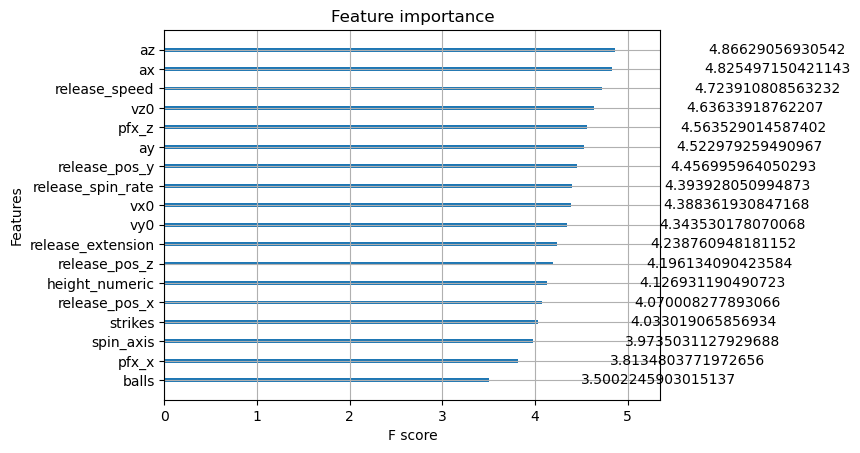

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xswing'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_31832\3915381827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xld'] = y_pred


In [ ]:
testing_identifiers.head()

,pitch_id_raw,xld
0,663364_455139_617228_4_75_10,0.353429
1,663364_455139_617228_3_75_10,0.190372
2,663364_455139_617228_2_75_10,0.306920
3,663364_455139_617228_1_75_10,0.258864
5,663364_593428_605347_4_72_10,0.248496


In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/swing_2022&3_xswing.csv")

# Offspeed Model 

In [ ]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

NameError: name 'offspeed_data' is not defined

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

152322

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


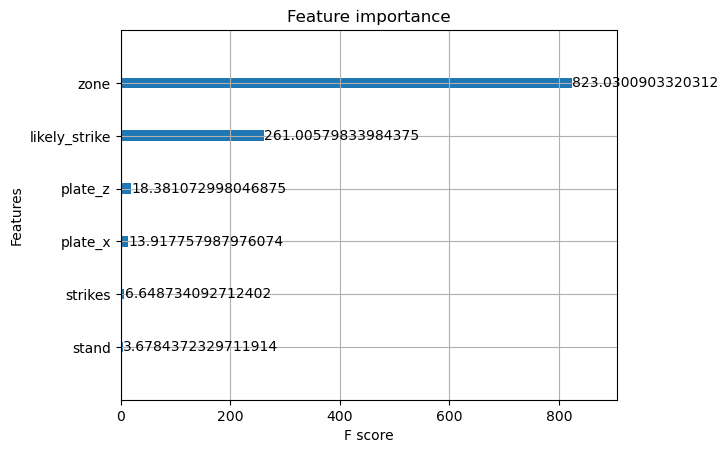

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

362561

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,deltaRE,is_strike,pitch_type_dict,likely_strike,prediction,probability_added,Unnamed: 0,mlb_id,mlb_name,team_name
1,716352_1_Bot,8,SI,2023-10-01,93.5,-2.60,5.68,"King, Michael",677951,650633,...,-0.028510,1,1.0,0,0.781290,0.218710,4412,669224,Austin Wells,yankees
11,716352_2_Bot,46,FF,2023-10-01,93.5,-2.82,5.71,"King, Michael",669004,650633,...,-0.038179,1,1.0,0,0.495411,0.504589,4412,669224,Austin Wells,yankees
28,716352_4_Bot,111,FF,2023-10-01,92.9,-2.66,5.89,"King, Michael",669004,650633,...,-0.038179,1,1.0,0,0.782323,0.217677,4412,669224,Austin Wells,yankees
37,716352_4_Bot,87,SI,2023-10-01,92.2,-2.76,5.67,"King, Michael",672580,650633,...,-0.111258,1,1.0,0,0.813712,0.186288,4412,669224,Austin Wells,yankees
39,716352_4_Top,115,SI,2023-10-01,90.1,-1.27,6.14,"Greinke, Zack",643396,425844,...,-0.043952,1,1.0,0,0.584764,0.415236,1898,521692,Salvador Perez,royals


### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches